<a href="https://colab.research.google.com/github/yura123123/Computer_Vision_NULP/blob/main/Lab_3/CV_lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import numpy as np
import pandas as pd
import plotly.express as px

from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout, concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, GlobalAveragePooling2D, Reshape, Resizing
from keras.applications.inception_v3 import InceptionV3

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from cv2 import merge
from tqdm import tqdm

In [ ]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
# x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# print('Training size', x_train.shape, x_train.max())
# print('Testing size', x_test.shape, x_test.max())

In [ ]:
# create train groups
# train_groups = [x_train[np.where(y_train == i)[0]] for i in np.unique(y_train)]
# test_groups = [x_test[np.where(y_test == i)[0]] for i in np.unique(y_train)]
# print('Training groups size', [x.shape[0] for x in train_groups])
# print('Testing groups size', [x.shape[0] for x in test_groups])

In [21]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('./data/fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size
= 0.3)

In [22]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [23]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4217, 4209, 4163, 4228, 4252, 4179, 4198, 4198, 4162, 4194]
test groups: [1783, 1791, 1837, 1772, 1748, 1821, 1802, 1802, 1838, 1806]


In [24]:
def gen_random_batch(in_groups, batch_halfsize = 8):
  out_img_a, out_img_b, out_score = [], [], []
  all_groups = list(range(len(in_groups)))
  for match_group in [True, False]:
    group_idx = np.random.choice(all_groups, size = batch_halfsize)
    out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
    if match_group:
      b_group_idx = group_idx
      out_score += [1]*batch_halfsize
    else:
      # anything but the same group
      non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
      b_group_idx = non_group_idx
      out_score += [0]*batch_halfsize

    out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]

    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

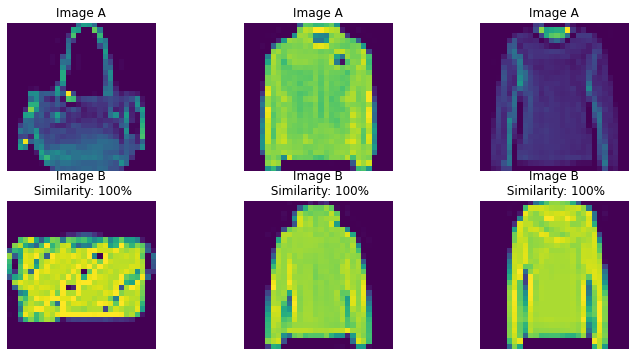

In [25]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
  ax1.imshow(c_a[:,:,0])
  ax1.set_title('Image A')
  ax1.axis('off')
  ax2.imshow(c_b[:,:,0])
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
  ax2.axis('off')

In [26]:
img_in = Input(shape=x_train.shape[1:], name='FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8 * 2 ** i, kernel_size=(3, 3), activation='linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16 * 2 ** i, kernel_size=(3, 3), activation='linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2, 2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation='linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs=[img_in], outputs=[n_layer], name='FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24,

In [29]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs =
[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          25040       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

In [31]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy',
metrics = ['mae'])

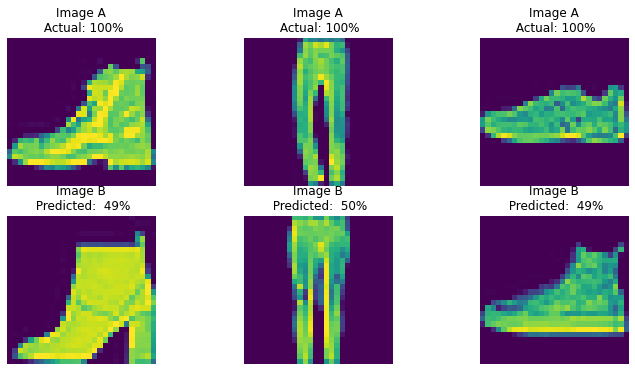

In [32]:
def show_model_output(nb_examples=3, nn_model=similarity_model, t_groups=test_groups):
    pv_a, pv_b, pv_sim = gen_random_batch(t_groups, nb_examples)
    pred_sim = nn_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100 * c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100 * p_d))
        ax2.axis('off')
    return fig


# a completely untrained model
_ = show_model_output()

In [35]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
  while True:
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
    yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups),
steps_per_epoch = 500,
validation_data=([valid_a, valid_b],
valid_sim), epochs = 10,verbose = True)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


500/500 [==============================] - 37s 63ms/step - loss: 0.3017 - mae: 0.2399 - val_loss: 0.0817 - val_mae: 0.0783
Epoch 2/10
500/500 [==============================] - 34s 68ms/step - loss: 0.0512 - mae: 0.0494 - val_loss: 0.0250 - val_mae: 0.0247
Epoch 3/10
500/500 [==============================] - 29s 58ms/step - loss: 0.0174 - mae: 0.0172 - val_loss: 0.0103 - val_mae: 0.0102
Epoch 4/10
500/500 [==============================] - 29s 57ms/step - loss: 0.0082 - mae: 0.0082 - val_loss: 0.0051 - val_mae: 0.0050
Epoch 5/10
500/500 [==============================] - 30s 60ms/step - loss: 0.0046 - mae: 0.0045 - val_loss: 0.0029 - val_mae: 0.0029
Epoch 6/10
500/500 [==============================] - 30s 60ms/step - loss: 0.0028 - mae: 0.0028 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 7/10
500/500 [==============================] - 30s 60ms/step - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0012 - val_mae: 0.0012
Epoch 8/10
500/500 [==============================] - 29s 58ms/step - los

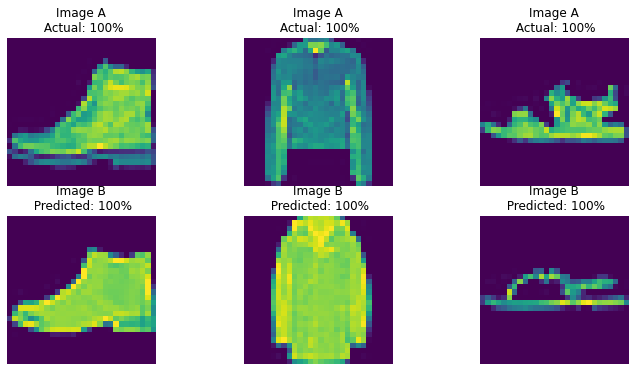

In [46]:
_ = show_model_output()

In [40]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose = True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose = True, batch_size = 128)

141/141 [==============================] - 9s 61ms/step


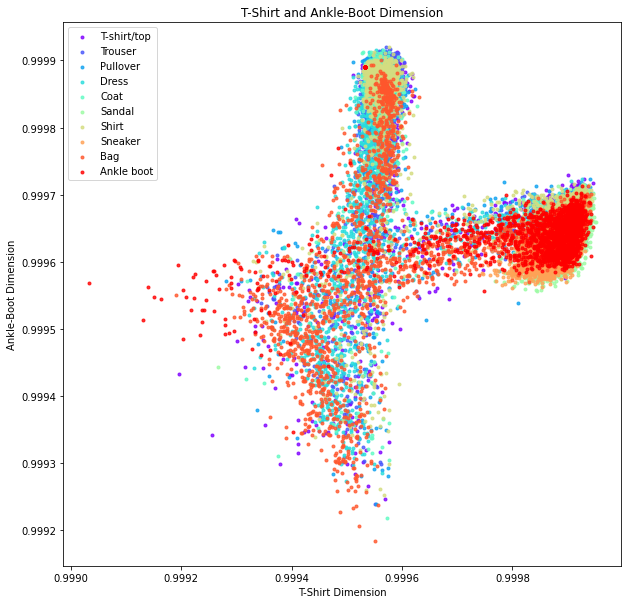

In [42]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],ankle_boot_score[np.where(y_test == c_group), 0],marker='.',color=c_color,linewidth='1',alpha=0.8,label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [43]:
x_test_features = feature_model.predict(x_test, verbose = True,batch_size=128)

141/141 [==============================] - 6s 42ms/step


In [44]:
%%time

tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.001s...
[t-SNE] Computed neighbors for 18000 samples in 21.245s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sa

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 85.9204559, gradient norm = 0.0015555 (50 iterations in 18.828s)
[t-SNE] Iteration 100: error = 84.3615875, gradient norm = 0.0006660 (50 iterations in 12.411s)
[t-SNE] Iteration 150: error = 83.8851929, gradient norm = 0.0004589 (50 iterations in 13.029s)
[t-SNE] Iteration 200: error = 83.6506653, gradient norm = 0.0003768 (50 iterations in 21.417s)
[t-SNE] Iteration 250: error = 83.5023499, gradient norm = 0.0003280 (50 iterations in 13.668s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.502350
[t-SNE] Iteration 300: error = 3.4507537, gradient norm = 0.0012677 (50 iterations in 13.355s)
[t-SNE] Iteration 350: error = 2.9059839, gradient norm = 0.0006130 (50 iterations in 10.321s)
[t-SNE] Iteration 400: error = 2.6181874, gradient norm = 0.0003788 (50 iterations in 10.023s)
[t-SNE] Iteration 450: error = 2.4406557, gradient norm = 0.0002663 (50 iterations in 9.857s)
[t-SNE] Iteration 500: error = 2.3193476, gradient norm = 0.0002

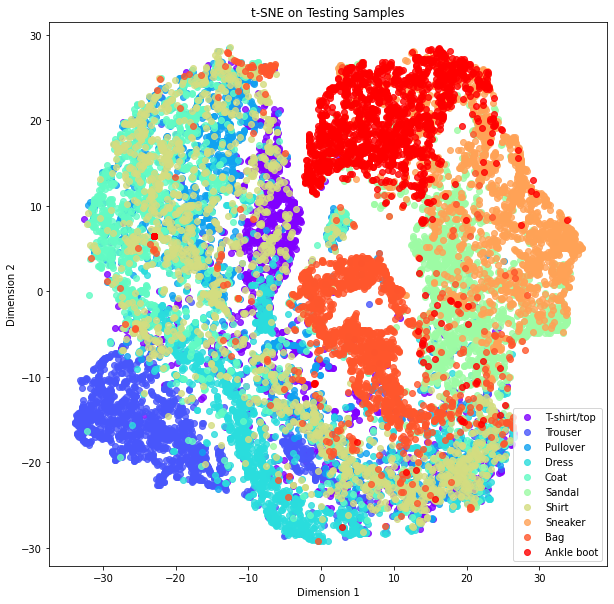

In [45]:
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth=1,
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)